# 1.0 Project Overview & Setup


## 1.1 Project Overview



This notebook builds a production-ready media anonymization backend service, PrivacyScrub.

The final product will be a Google Cloud Run service running a FastAPI backend. This service will serve a secure, scalable HTTP API for anonymizing images and videos. A front-end application can send media files and configuration options, and will receive an anonymized version in response.

This notebook will serve as a **factory pipeline** to:
* Install all necessary Python libraries and the Google Cloud SDK.
* Authenticate the user for Google Cloud access.
* Write the Python code for the FastAPI service (main.py), its dependencies (requirements.txt), and a Dockerfile for deployment.
* Package and deploy the service as a container to Google Cloud Run.
* Run a live test against the deployed API endpoint to verify its functionality.

## 1.2 Preliminary Setup (Manual Steps)



Before running this notebook, please complete these steps in your Google Cloud Console.

1. Configure Google Cloud Project & Billing
* Go to the Google Cloud Console.
* At the top of the page, select or create the Google Cloud project you want to use.
* In the navigation menu (☰), go to Billing.
* Ensure your project is linked to an active billing account. You cannot enable or use APIs without this.

2. Enable All 6 Required APIs
* In the navigation menu, go to APIs & Services > Library.
* Search for and Enable each of the following 6 APIs one by one.
* * Cloud Vision API (For PII detection: faces, text, logos)
* * Cloud Run API (To run our FastAPI service)
* * Cloud Build API (To build our service's container)
* * Artifact Registry API (To store the container)
* * Cloud Storage API (For temporary video file storage)
* * Cloud Tasks API (For the asynchronous video processing queue)

3. Create GCS Bucket for Temp Video Files
* In the navigation menu, go to Cloud Storage > Buckets.
* Click Create.
* Give it a globally unique name (e.g., privacyscrub-temp-videos-YOUR-PROJECT-ID). Note this name.
* Choose your GCP_REGION (the same one you'll use for deployment).
* Select Uniform for access control.
* Click Create.
* After creating, click the bucket name, go to the Lifecycle tab, and add a rule to Delete objects after 1 day.

4. Set IAM Permissions
* In the navigation menu, go to IAM & Admin > IAM.
* Find your user account (the one you're logged into Colab with).
* Click the pencil icon (Edit principal) on the far right.
* Click Add another role and add the following 4 roles:
* Cloud Vision AI User (To use the Vision API)
* Cloud Run Admin (To deploy and manage the service)
* Cloud Storage Admin (To manage the temp bucket and set permissions)
* Cloud Tasks Admin (To create and manage the video queue)
* Click Save.

5. Create Colab Secrets
* In this Colab notebook, click the key icon (🔑) in the left-hand sidebar.
* Add these 4 secrets:
* * GCP_PROJECT_ID: Your Google Cloud Project ID (e.g., privacyscrub-project).
* * GCP_REGION: The region to deploy to (e.g., us-central1).
* * SERVICE_NAME: The name for your API service (e.g., privacyscrub-api).
* * GCS_BUCKET_NAME: The unique bucket name you created in step 3.

## 1.3 Install Libraries

In [ ]:
# --- 1.3 Install Libraries ---

print("Installing Google Cloud SDK...")
# This installs the gcloud CLI tool
!curl -sSL https://sdk.cloud.google.com | bash -s -- --disable-prompts > /dev/null 2>&1
# Add gcloud to our path
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/google-cloud-sdk/bin"
# Suppress prompts
!gcloud config set core/disable_prompts true

print("Installing Python packages for API, processing, and GCP...")
!pip install -U \
  "fastapi[all]" \
  uvicorn \
  google-cloud-vision \
  google-cloud-storage \
  google-cloud-tasks \
  opencv-python-headless \
  pillow \
  moviepy \
  gcsfs

print("Installation complete. DO NOT restart the runtime; go straight to 1.4 imports.")


Installing Google Cloud SDK...
Updated property [core/disable_prompts].
Installing Python packages for API, processing, and GCP...
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
Installation complete. DO NOT restart the runtime; go straight to 1.4 imports.


## 1.4 Import Libraries

In [ ]:
# --- 1.4 Import Libraries ---

# Core Python and Notebook/GCP integration
import os
import shutil
import zipfile
import json
import requests
import io
from getpass import getpass
from google.colab import auth, userdata, files

# Image/Video Processing
from PIL import Image, ImageDraw, ImageFilter
import cv2
import moviepy as mp

# Google Cloud Services
from google.cloud import vision
from google.cloud import storage
from google.cloud import tasks_v2

print("Core libraries imported.")
print("Section 1.0 complete. Ready to proceed to 1.5 (Authentication).")

Core libraries imported.
Section 1.0 complete. Ready to proceed to 1.5 (Authentication).


## 1.5 Authenticate GCP

In [ ]:
# --- 1.5 Authenticate GCP ---

print("Authenticating Google Cloud...")

# Authenticate Colab user for Google Cloud SDK
auth.authenticate_user()

# Set project config for the gcloud CLI
try:
    GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')
    GCP_REGION = userdata.get('GCP_REGION')
    !gcloud config set project {GCP_PROJECT_ID}
    !gcloud config set functions/region {GCP_REGION}
    !gcloud config set run/region {GCP_REGION}
except Exception as e:
    print("ERROR: Could not get GCP secrets. Please complete step 1.2.5 (Create Colab Secrets).")
    raise e

print(f"\nGoogle Cloud SDK configured for project: {GCP_PROJECT_ID} in region: {GCP_REGION}")
print("Section 1.5 complete.")

Authenticating Google Cloud...
INFORMATION: Project 'privacyscrub-backend' has no 'environment' tag set. Use either 'Production', 'Development', 'Test', or 'Staging'. Add an 'environment' tag using `gcloud resource-manager tags bindings create`.
Updated property [core/project].
Updated property [functions/region].
Updated property [run/region].

Google Cloud SDK configured for project: privacyscrub-backend in region: us-central1
Section 1.5 complete.


# 2.0 Core Anonymization Logic

## 2.1 Helper Functions (utils.py)

In [ ]:
# --- 2.1 Helper Functions (utils.py) ---

import io
import os
import uuid
from PIL import Image, ImageDraw, ImageFilter, ExifTags
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.VideoClip import VideoClip
import numpy as np
from google.cloud import vision, storage, tasks_v2
from google.protobuf import json_format
import json

print("Writing core logic to function_source/utils.py...")

# Create the directory to hold our function's source code if it doesn't exist
FUNCTION_SOURCE_PATH = "/content/function_source"
if not os.path.exists(FUNCTION_SOURCE_PATH):
    os.makedirs(FUNCTION_SOURCE_PATH)

Writing core logic to function_source/utils.py...


In [ ]:
%%writefile {FUNCTION_SOURCE_PATH}/utils.py
import io
import os
import uuid
import numpy as np
from PIL import Image, ImageDraw, ImageFilter, ExifTags
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.VideoClip import VideoClip
from google.cloud import vision, storage, tasks_v2
from google.protobuf import json_format
import json
from datetime import datetime, timezone # Import for job polling

# --- 1. Configuration (from Secrets) ---
GCP_PROJECT_ID = os.environ.get("GCP_PROJECT_ID", "privacyscrub-backend")
GCP_REGION = os.environ.get("GCP_REGION", "us-central1")
GCS_BUCKET_NAME = os.environ.get("GCS_BUCKET_NAME", "")
VIDEO_QUEUE_ID = os.environ.get("VIDEO_QUEUE_ID", "video-processing-queue")
API_SERVICE_URL = os.environ.get("API_SERVICE_URL", "") # We'll set this later
TASKS_CLIENT = None
STORAGE_CLIENT = None
VISION_CLIENT = None

def get_vision_client():
    """Initializes and returns a reusable Vision API client."""
    global VISION_CLIENT
    if VISION_CLIENT is None:
        VISION_CLIENT = vision.ImageAnnotatorClient()
    return VISION_CLIENT

def get_storage_client():
    """Initializes and returns a reusable Cloud Storage client."""
    global STORAGE_CLIENT
    if STORAGE_CLIENT is None:
        STORAGE_CLIENT = storage.Client()
    return STORAGE_CLIENT

def get_tasks_client():
    """Initializes and returns a reusable Cloud Tasks client."""
    global TASKS_CLIENT
    if TASKS_CLIENT is None:
        TASKS_CLIENT = tasks_v2.CloudTasksClient()
    return TASKS_CLIENT

# --- 2. Google Cloud API Helpers ---

def detect_pii_features(image_bytes, options):
    """
    Calls the Google Vision API to detect features based on request options.
    (SRS 3.1, 4.1)
    """
    client = get_vision_client()
    image = vision.Image(content=image_bytes)

    features_to_detect = []

    targets = options.get("targets", {})

    if targets.get("faces", False):
        features_to_detect.append(vision.Feature(type_=vision.Feature.Type.FACE_DETECTION))
    if targets.get("plates", False):
        features_to_detect.append(vision.Feature(type_=vision.Feature.Type.OBJECT_LOCALIZATION))
    if targets.get("text", False):
        features_to_detect.append(vision.Feature(type_=vision.Feature.Type.TEXT_DETECTION))
    if targets.get("logos", False):
        features_to_detect.append(vision.Feature(type_=vision.Feature.Type.LOGO_DETECTION))

    if not features_to_detect:
        # Return an empty, but valid, response object
        return vision.AnnotateImageResponse()

    request = vision.AnnotateImageRequest(image=image, features=features_to_detect)
    response = client.annotate_image(request=request)

    if response.error.message:
        raise Exception(f"Vision API Error: {response.error.message}")

    return response

def extract_bounding_boxes(response, options):
    """
    Parses the Vision API response into a simple list of bounding boxes.
    (SRS 5.4, 5.3.1)
    """
    boxes = []
    confidence_threshold = options.get("confidence_threshold", 0.5)

    targets = options.get("targets", {})

    if targets.get("faces", False) and response.face_annotations:
        for face in response.face_annotations:
            if face.detection_confidence >= confidence_threshold:
                vertices = face.fd_bounding_poly.vertices
                boxes.append({
                    "type": "face",
                    "confidence": face.detection_confidence,
                    "bbox": [vertices[0].x, vertices[0].y, vertices[2].x, vertices[2].y]
                })

    if targets.get("text", False) and response.text_annotations:
        # First item is the full text, skip it
        for text in response.text_annotations[1:]:
             # The 'score' field is not always present for text, default to 1.0
             text_confidence = getattr(text, 'score', 1.0)
             if text_confidence >= confidence_threshold:
                vertices = text.bounding_poly.vertices
                boxes.append({
                    "type": "text",
                    "confidence": text_confidence,
                    "bbox": [vertices[0].x, vertices[0].y, vertices[2].x, vertices[2].y]
                })

    if targets.get("logos", False) and response.logo_annotations:
        for logo in response.logo_annotations:
            if logo.score >= confidence_threshold:
                vertices = logo.bounding_poly.vertices
                boxes.append({
                    "type": "logo",
                    "confidence": logo.score,
                    "bbox": [vertices[0].x, vertices[0].y, vertices[2].x, vertices[2].y]
                })

    if targets.get("plates", False) and response.localized_object_annotations:
        for obj in response.localized_object_annotations:
            # Filter for license plates
            if obj.name == "License plate" and obj.score >= confidence_threshold:
                vertices = obj.bounding_poly.normalized_vertices
                # We now store normalized, they will be converted in the image processor
                boxes.append({
                    "type": "license_plate",
                    "confidence": obj.score,
                    "bbox_normalized": [vertices[0].x, vertices[0].y, vertices[2].x, vertices[2].y]
                })

    return boxes

def upload_to_gcs(file_bytes, destination_blob_name):
    """Uploads bytes to GCS and returns the GCS URI."""
    storage_client = get_storage_client()
    bucket = storage_client.bucket(GCS_BUCKET_NAME)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_string(file_bytes, content_type='application/octet-stream')
    return f"gs://{GCS_BUCKET_NAME}/{destination_blob_name}"

def download_from_gcs(gcs_uri):
    """Downloads bytes from a GCS URI."""
    storage_client = get_storage_client()
    bucket_name, blob_name = gcs_uri.replace("gs://", "").split("/", 1)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    file_bytes = blob.download_as_bytes()
    return file_bytes

def delete_from_gcs(gcs_uri):
    """Deletes a blob from GCS."""
    try:
        storage_client = get_storage_client()
        bucket_name, blob_name = gcs_uri.replace("gs://", "").split("/", 1)
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        blob.delete()
    except Exception as e:
        print(f"Warning: Failed to delete blob {gcs_uri}. Error: {e}")

def create_video_task(job_id, gcs_uri, options):
    """Creates a Cloud Task to process a video."""
    tasks_client = get_tasks_client()

    parent = tasks_client.queue_path(GCP_PROJECT_ID, GCP_REGION, VIDEO_QUEUE_ID)

    task_payload = {
        "job_id": job_id,
        "gcs_uri": gcs_uri,
        "options": options
    }

    task = {
        "http_request": {
            "http_method": tasks_v2.HttpMethod.POST,
            "url": f"{API_SERVICE_URL}/v1/internal/process-video-job",
            "headers": {"Content-Type": "application/json"},
            "body": json.dumps(task_payload).encode()
        },
        "dispatch_deadline": {
            "seconds": 600  # 10 minute deadline
        }
    }

    return tasks_client.create_task(parent=parent, task=task)

# --- 3. Image & Metadata Processing (PIL) ---

def strip_exif(image):
    """
    Removes all EXIF metadata from a PIL Image.
    (SRS 3.1, Item 5)
    """
    data = list(image.getdata())
    image_without_exif = Image.new(image.mode, image.size)
    image_without_exif.putdata(data)

    # Also preserve original format if possible
    image_without_exif.format = image.format
    return image_without_exif

def anonymize_image(image_bytes, options):
    """
    Main function to process a single image.
    1. Loads image
    2. Strips EXIF
    3. Calls Vision API
    4. Applies anonymization
    5. Returns anonymized image bytes OR coordinates
    (SRS 5.1.1, 5.2)
    """
    # Load image and strip EXIF
    original_image = Image.open(io.BytesIO(image_bytes))
    image = strip_exif(original_image)

    # Re-save to bytes for Vision API
    with io.BytesIO() as output:
        # Use PNG for API calls to avoid compression artifacts if possible
        image.save(output, format=original_image.format or "PNG")
        image_bytes_for_api = output.getvalue()

    # Call Vision API
    api_response = detect_pii_features(image_bytes_for_api, options)
    boxes = extract_bounding_boxes(api_response, options)

    # Handle normalized coords for license plates
    img_width, img_height = image.size
    final_boxes = []
    for box in boxes:
        if "bbox_normalized" in box:
            norm = box["bbox_normalized"]
            box["bbox"] = [
                norm[0] * img_width, norm[1] * img_height,
                norm[2] * img_width, norm[3] * img_height
            ]
        final_boxes.append(box)

    # Return coordinates_only if requested (SRS 5.2)
    if options.get("coordinates_only", False):
        return final_boxes, None # Return JSON, no image

    # Apply anonymization to the image
    mode = options.get("mode", "blur")
    draw = ImageDraw.Draw(image)

    for box_data in final_boxes:
        box = box_data.get("bbox")
        if not box: continue # Skip if box wasn't created (e.g., normalized)

        # Ensure coordinates are within image bounds
        x1, y1, x2, y2 = [
            max(0, int(box[0])),
            max(0, int(box[1])),
            min(img_width, int(box[2])),
            min(img_height, int(box[3]))
        ]

        if x1 >= x2 or y1 >= y2:
            continue

        if mode == "black_box":
            draw.rectangle([x1, y1, x2, y2], fill="black")

        elif mode == "pixelate":
            # Coarse pixelation (SRS 5.2)
            region = image.crop((x1, y1, x2, y2))
            # Calculate pixelation size, e.g., 1/12th of region, min 1px
            w, h = region.size
            if w == 0 or h == 0: continue
            pixel_size = max(1, min(w, h) // 12)
            region = region.resize((w // pixel_size, h // pixel_size), Image.Resampling.BOX)
            region = region.resize((w, h), Image.Resampling.NEAREST)
            image.paste(region, (x1, y1))

        else: # Default to "blur" (SRS 5.2)
            region = image.crop((x1, y1, x2, y2))
            w, h = region.size
            if w == 0 or h == 0: continue
            # Strong Gaussian blur
            blur_radius = max(2, max(w, h) // 10) # Min radius of 2
            region = region.filter(ImageFilter.GaussianBlur(radius=blur_radius))
            image.paste(region, (x1, y1))

    del draw

    # Save final image to bytes
    with io.BytesIO() as output:
        # Preserve original format if known (JPEG, PNG), default to JPEG
        output_format = original_image.format if original_image.format in ["JPEG", "PNG"] else "JPEG"
        image.save(output, format=output_format)
        anonymized_bytes = output.getvalue()

    return None, anonymized_bytes # Return no JSON, yes image


# --- 4. Video Processing (MoviePy) ---

def anonymize_video_frame(frame_image, options, vision_client):
    """
    Processes a single video frame (as a numpy array) for anonymization.
    This function is designed to be called by moviepy's fl_image.
    """
    # Convert numpy array (frame) to PIL Image
    pil_image = Image.fromarray(frame_image)

    # Save PIL image to bytes
    with io.BytesIO() as output:
        pil_image.save(output, format="JPEG")
        frame_bytes = output.getvalue()

    api_response = detect_pii_features(frame_bytes, options)
    boxes = extract_bounding_boxes(api_response, options)

    # Handle normalized coords for license plates
    img_width, img_height = pil_image.size
    final_boxes = []
    for box in boxes:
        if "bbox_normalized" in box:
            norm = box["bbox_normalized"]
            box["bbox"] = [
                norm[0] * img_width, norm[1] * img_height,
                norm[2] * img_width, norm[3] * img_height
            ]
        final_boxes.append(box)

    # Apply anonymization
    mode = options.get("mode", "blur")
    draw = ImageDraw.Draw(pil_image)

    for box_data in final_boxes:
        box = box_data.get("bbox")
        if not box: continue

        x1, y1, x2, y2 = [
            max(0, int(box[0])),
            max(0, int(box[1])),
            min(img_width, int(box[2])),
            min(img_height, int(box[3]))
        ]

        if x1 >= x2 or y1 >= y2:
            continue

        if mode == "black_box":
            draw.rectangle([x1, y1, x2, y2], fill="black")
        elif mode == "pixelate":
            region = pil_image.crop((x1, y1, x2, y2))
            w, h = region.size
            if w == 0 or h == 0: continue
            pixel_size = max(1, min(w, h) // 12)
            if pixel_size == 0: continue
            region = region.resize((w // pixel_size, h // pixel_size), Image.Resampling.BOX)
            region = region.resize((w, h), Image.Resampling.NEAREST)
            pil_image.paste(region, (x1, y1))
        else: # "blur"
            region = pil_image.crop((x1, y1, x2, y2))
            w, h = region.size
            if w == 0 or h == 0: continue
            blur_radius = max(2, max(w, h) // 10)
            region = region.filter(ImageFilter.GaussianBlur(radius=blur_radius))
            pil_image.paste(region, (x1, y1))

    del draw

    # Convert PIL Image back to numpy array for moviepy
    return np.array(pil_image)

Overwriting /content/function_source/utils.py


# 3.0 Write & Deploy Backend API

## 3.1 Write requirements.txt for the Function

In [ ]:
%%writefile {FUNCTION_SOURCE_PATH}/requirements.txt
# FastAPI Server
fastapi[all]
uvicorn

# Google Cloud Services
google-cloud-vision
google-cloud-storage
google-cloud-tasks

# Media Processing
opencv-python-headless
pillow
moviepy

# GCS File System
gcsfs

# Required for FastAPI File Uploads
python-multipart

Writing /content/function_source/requirements.txt


## 3.2 Write main.py (The API Code)

In [ ]:
%%writefile {FUNCTION_SOURCE_PATH}/main.py
import os
import io
import json
import uuid
import tempfile
from contextlib import asynccontextmanager
from typing import Optional, List, Dict, Any
import numpy as np
from datetime import datetime, timezone
from google.cloud import storage

# FastAPI & Pydantic
from fastapi import FastAPI, UploadFile, File, Form, HTTPException, Request, BackgroundTasks, Response, status
from fastapi.responses import StreamingResponse
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field

# Our core logic
import utils

# --- 1. Pydantic Models (SRS 5.2) ---
# ... (code unchanged) ...
class Targets(BaseModel):
    faces: bool = True
    plates: bool = True
    text: bool = False
    logos: bool = False

class AnonymizationOptions(BaseModel):
    targets: Targets = Field(default_factory=Targets)
    mode: str = "blur"
    confidence_threshold: float = 0.5
    coordinates_only: bool = False
    compliance_profile: Optional[str] = None
    roi: Optional[List[int]] = None

# --- 2. Compliance Profile Logic (SRS 6.0) ---
# ... (code unchanged) ...
def apply_compliance_profile(options: dict) -> dict:
    """Applies defaults based on the compliance_profile."""
    profile = options.get("compliance_profile")
    if not profile:
        return options

    defaults = {}
    if profile == "gdpr_strict":
        defaults = {
            "targets": {"faces": True, "plates": True, "text": True, "logos": True},
            "mode": "blur"
        }
    elif profile == "ccpa_default":
        defaults = {
            "targets": {"faces": True, "plates": True, "text": True, "logos": False},
            "mode": "blur"
        }
    elif profile == "hipaa_like":
        defaults = {
            "targets": {"faces": True, "plates": True, "text": True, "logos": False},
            "mode": "black_box", # Stricter than blur
            "confidence_threshold": 0.4 # More aggressive
        }

    # User-provided options override profile defaults (SRS 6.1)
    # Deep merge 'targets'
    if "targets" in defaults and "targets" in options:
        merged_targets = {**defaults["targets"], **options["targets"]}
        final_options = {**defaults, **options, "targets": merged_targets}
    else:
        final_options = {**defaults, **options}

    return final_options

def parse_options_json(options_str: str) -> dict:
    """Parses the options JSON string and applies compliance logic."""
    try:
        user_options = json.loads(options_str)
    except json.JSONDecodeError:
        raise HTTPException(status_code=400, detail="Invalid 'options' JSON.")

    # Validate with Pydantic model (applies defaults for missing fields)
    base_options = AnonymizationOptions().model_dump()
    # Deep merge base defaults with user options
    if "targets" in user_options:
        merged_targets = {**base_options["targets"], **user_options["targets"]}
        valid_options = {**base_options, **user_options, "targets": merged_targets}
    else:
        valid_options = {**base_options, **user_options}

    # Apply compliance profile defaults (which can be overridden)
    final_options = apply_compliance_profile(valid_options)

    # Re-validate to ensure final model is correct
    try:
        AnonymizationOptions(**final_options)
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Invalid options after merge: {e}")

    return final_options


# --- 3. FastAPI App & Endpoints (SRS 5.3) ---
@asynccontextmanager
async def lifespan(app: FastAPI):
    # On startup, load the API_SERVICE_URL from env vars
    utils.API_SERVICE_URL = os.environ.get("API_SERVICE_URL", "")

    if not utils.API_SERVICE_URL:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! WARNING: API_SERVICE_URL env var not set.                         !!!")
        print("!!! Video processing (/v1/anonymize-video) will fail.                 !!!")
        print("!!! This is expected on first deploy. Redeploy with the URL to fix.   !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    else:
        print(f"API_SERVICE_URL set to: {utils.API_SERVICE_URL}")

    # Set other env vars for utils
    utils.GCP_PROJECT_ID = os.environ.get("GCP_PROJECT_ID", "")
    utils.GCP_REGION = os.environ.get("GCP_REGION", "")
    utils.GCS_BUCKET_NAME = os.environ.get("GCS_BUCKET_NAME", "")
    utils.VIDEO_QUEUE_ID = os.environ.get("VIDEO_QUEUE_ID", "video-processing-queue")

    yield
    # On shutdown (nothing to do)

app = FastAPI(lifespan=lifespan)

# Add CORS middleware to allow all origins
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

@app.get("/")
async def root():
    return {"status": "ok", "service": "PrivacyScrub v1.0"}

@app.post("/v1/anonymize-image", tags=["Media Anonymization"])
async def anonymize_image(
    file: UploadFile = File(..., description="JPEG or PNG image file."),
    options: str = Form(..., description="JSON string of AnonymizationOptions.")
):
    """
    Synchronously processes a single image for PII.
    (SRS 5.1.1, 5.3.1)
    """
    if file.content_type not in ["image/jpeg", "image/png"]:
        raise HTTPException(status_code=400, detail="Invalid file type. Only JPEG and PNG are supported.")

    parsed_options = parse_options_json(options)
    image_bytes = await file.read()

    try:
        json_result, image_result = utils.anonymize_image(image_bytes, parsed_options)
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Image processing error: {e}")

    if parsed_options.get("coordinates_only", False):
        return {"detected_objects": json_result}

    # Return the raw image bytes with the correct media type
    return Response(content=image_result, media_type=file.content_type)


@app.post("/v1/anonymize-video",
          tags=["Media Anonymization"],
          status_code=status.HTTP_202_ACCEPTED)
async def anonymize_video(
    background_tasks: BackgroundTasks,
    file: UploadFile = File(..., description="MP4 video file."),
    options: str = Form(..., description="JSON string of AnonymizationOptions.")
):
    """
    Asynchronously processes a video file for PII.
    1. Uploads video to GCS.
    2. Queues a Cloud Task for processing.
    3. Returns a job_id.
    (SRS 5.1.2, 5.3.2)
    """
    if file.content_type != "video/mp4":
        raise HTTPException(status_code=400, detail="Invalid file type. Only MP4 is supported.")

    # We must have the API_SERVICE_URL for this to work
    if not utils.API_SERVICE_URL:
        raise HTTPException(status_code=500, detail="Service not configured for video processing (API_SERVICE_URL not set). Please redeploy with the correct environment variable.")

    parsed_options = parse_options_json(options)
    job_id = f"job_{uuid.uuid4()}"
    gcs_path = f"input/{job_id}.mp4"

    try:
        video_bytes = await file.read()
        gcs_uri = utils.upload_to_gcs(video_bytes, gcs_path)

        utils.create_video_task(job_id, gcs_uri, parsed_options)

    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Failed to queue video: {e}")

    return {"job_id": job_id, "status": "PENDING"}


@app.get("/v1/jobs/{job_id}", tags=["Job Status"])
async def get_job_status(job_id: str):
    """
    Checks the status of an asynchronous video job.
    Uses GCS object presence as a "stateless" job tracker.
    (SRS 5.3.3)
    """
    try:
        storage_client = utils.get_storage_client()
        bucket = storage_client.bucket(utils.GCS_BUCKET_NAME)

        # 1. Check for failure
        error_blob = bucket.blob(f"error/{job_id}.txt")
        if error_blob.exists(storage_client):
            error_message = error_blob.download_as_text()
            return {"job_id": job_id, "status": "FAILED", "error": error_message}

        # 2. Check for success
        output_blob = bucket.blob(f"output/{job_id}.mp4")
        if output_blob.exists(storage_client):

            def iterfile():
                # Stream the file in chunks
                with output_blob.open("rb") as f:
                    yield from f

            return StreamingResponse(
                iterfile(),
                media_type="video/mp4",
                headers={"Content-Disposition": f"attachment; filename=anonymized_{job_id}.mp4"}
            )

        # 3. Check for pending/running
        input_blob = bucket.blob(f"input/{job_id}.mp4")
        if input_blob.exists(storage_client):
             # Check age to see if it's "stuck"
            input_blob.reload()
            if input_blob.time_created:
                age_seconds = (datetime.now(timezone.utc) - input_blob.time_created).total_seconds()
                if age_seconds > 3600: # 1 hour timeout
                     return {"job_id": job_id, "status": "FAILED", "error": "Job timed out and was stuck in input queue."}

            return {"job_id": job_id, "status": "RUNNING"} # or PENDING

        # 4. If nothing is found, it's a bad job_id
        raise HTTPException(status_code=404, detail="Job not found.")

    except HTTPException as he:
        # Re-raise HTTPExceptions directly
        raise he
    except Exception as e:
        # Catch any other unhandled exception
        print(f"!!! UNHANDLED EXCEPTION in get_job_status: {e}")
        raise HTTPException(status_code=500, detail=f"Internal error retrieving job status: {str(e)}")


# --- 4. Internal Task Handler (Called by Cloud Tasks) ---
# ... (this part is unchanged) ...
class JobPayload(BaseModel):
    job_id: str
    gcs_uri: str
    options: Dict[str, Any]

@app.post("/v1/internal/process-video-job", include_in_schema=False)
async def process_video_job(payload: JobPayload, background_tasks: BackgroundTasks):
    """
    Internal endpoint called by Cloud Tasks to do the heavy lifting.
    (Not for public use)
    """
    job_id = payload.job_id
    gcs_uri = payload.gcs_uri
    options = payload.options

    temp_in_path = None
    temp_out_path = None

    try:
        # 1. Download video from GCS
        video_bytes = utils.download_from_gcs(gcs_uri)

        # 2. Write to a temp file for moviepy
        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp4") as f_in:
            f_in.write(video_bytes)
            temp_in_path = f_in.name

        with tempfile.NamedTemporaryFile(delete=False, suffix=".mp4") as f_out:
            temp_out_path = f_out.name

        # 3. Process the video
        clip = utils.VideoFileClip(temp_in_path)

        # Get a single vision client for all frames
        vision_client = utils.get_vision_client()

        # Apply anonymization to each frame
        # Use the correct v2.0 method name
        anon_clip = clip.image_transform(
            lambda frame: utils.anonymize_video_frame(frame, options, vision_client)
        )

        # Write the processed video to the temp output file
        # Use 'libx264' for good compression/compatibility, 'aac' for audio
        anon_clip.write_videofile(temp_out_path, codec="libx264", audio_codec="aac")
        clip.close()

        # 4. Upload result to GCS
        output_gcs_path = f"output/{job_id}.mp4"
        with open(temp_out_path, "rb") as f:
            utils.upload_to_gcs(f.read(), output_gcs_path)

        # 5. Add input file to background cleanup (success)
        background_tasks.add_task(utils.delete_from_gcs, gcs_uri)

    except Exception as e:
        # If it fails, write an error file to GCS
        error_message = f"Failed to process video {job_id}: {str(e)}"
        print(error_message)
        try:
            utils.upload_to_gcs(error_message.encode('utf-8'), f"error/{job_id}.txt")
            # Still try to delete the input file on failure
            background_tasks.add_task(utils.delete_from_gcs, gcs_uri)
        except:
            pass # Failed to even write the error

    finally:
        # 6. Clean up local temp files
        if temp_in_path and os.path.exists(temp_in_path):
            os.remove(temp_in_path)
        if temp_out_path and os.path.exists(temp_out_path):
            os.remove(temp_out_path)

    return {"status": "processing_complete"}

Overwriting /content/function_source/main.py


## 3.3 Create Dockerfile

In [ ]:
%%writefile {FUNCTION_SOURCE_PATH}/Dockerfile
# Start from a standard Python 3.11 base image
FROM python:3.11-slim

# Set the working directory inside the container
WORKDIR /app

# Copy the requirements file first and install dependencies
# This caches the install layer unless requirements.txt changes
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt

# Copy all our source code (main.py, utils.py) into the container
COPY . .

# Expose the port that FastAPI will run on
EXPOSE 8080

# The command to run our FastAPI server using uvicorn
# This is the standard for Cloud Run
CMD ["uvicorn", "main:app", "--host", "0.0.0.0", "--port", "8080"]

Overwriting /content/function_source/Dockerfile


## 3.4 Create Cloud Tasks Queue

In [ ]:
# --- 3.4 Create Cloud Tasks Queue ---

print("Creating the Cloud Tasks queue for video processing...")

# Get region from secrets
GCP_REGION = userdata.get('GCP_REGION')
VIDEO_QUEUE_ID = "video-processing-queue" # Must match the one in utils.py

# The "|| echo" part prevents an error if it already exists
!gcloud tasks queues create {VIDEO_QUEUE_ID} --location={GCP_REGION} || echo "Queue '{VIDEO_QUEUE_ID}' already exists in location '{GCP_REGION}'."

print(f"\nQueue '{VIDEO_QUEUE_ID}' is ready.")

Creating the Cloud Tasks queue for video processing...
Created queue [us-central1/video-processing-queue].

Queue 'video-processing-queue' is ready.


## 3.5 First Deploy

In [ ]:
# --- 3.5 First Deploy (This will take 5-10 minutes) ---

print("Starting FIRST deployment to Cloud Run...")
print("This deploy will create the service and get its URL.")
print("It is EXPECTED to see a 'WARNING: API_SERVICE_URL env var not set' in the logs.")

# Get all our secret variables
SERVICE_NAME = userdata.get('SERVICE_NAME')
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')
GCP_REGION = userdata.get('GCP_REGION')
GCS_BUCKET_NAME = userdata.get('GCS_BUCKET_NAME')
VIDEO_QUEUE_ID = "video-processing-queue"

# Get the Project Number to find the default service account
# We need to capture this into a Python variable to use it
project_number_output = !gcloud projects describe {GCP_PROJECT_ID} --format='value(projectNumber)'
PROJECT_NUMBER = project_number_output[0]
SERVICE_ACCOUNT_EMAIL = f"{PROJECT_NUMBER}-compute@developer.gserviceaccount.com"

print(f"Deploying '{SERVICE_NAME}' using service account: {SERVICE_ACCOUNT_EMAIL}")

# Run the deployment command
!gcloud run deploy {SERVICE_NAME} \
  --source={FUNCTION_SOURCE_PATH} \
  --region={GCP_REGION} \
  --allow-unauthenticated \
  --service-account={SERVICE_ACCOUNT_EMAIL} \
  --set-env-vars="GCP_PROJECT_ID={GCP_PROJECT_ID},GCP_REGION={GCP_REGION},GCS_BUCKET_NAME={GCS_BUCKET_NAME},VIDEO_QUEUE_ID={VIDEO_QUEUE_ID},API_SERVICE_URL=FIRST_DEPLOY" \
  --memory=2Gi \
  --cpu=1 \
  --timeout=300s \
  --quiet

print("\n--- First deploy complete. ---")

Starting FIRST deployment to Cloud Run...
This deploy will create the service and get its URL.
It is EXPECTED to see a 'WARNING: API_SERVICE_URL env var not set' in the logs.
Deploying 'privacyscrub-api' using service account: 138163390354-compute@developer.gserviceaccount.com
Building using Dockerfile and deploying container to Cloud Run service [privacyscrub-api] in project [privacyscrub-backend] region [us-central1]
Service [privacyscrub-api] revision [privacyscrub-api-00017-qns] has been deployed and is serving 100 percent of traffic.
Service URL: https://privacyscrub-api-138163390354.us-central1.run.app

--- First deploy complete. ---


## 3.6 Redeploy to Finalize

In [ ]:
# --- 3.6 Redeploy to Finalize (This will take 2-3 minutes) ---

print("Starting SECOND deployment to finalize service...")

# Get all our secret variables again
SERVICE_NAME = userdata.get('SERVICE_NAME')
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')
GCP_REGION = userdata.get('GCP_REGION')
GCS_BUCKET_NAME = userdata.get('GCS_BUCKET_NAME')
VIDEO_QUEUE_ID = "video-processing-queue"

# Get the Project Number and Service Account
project_number_output = !gcloud projects describe {GCP_PROJECT_ID} --format='value(projectNumber)'
PROJECT_NUMBER = project_number_output[0]
SERVICE_ACCOUNT_EMAIL = f"{PROJECT_NUMBER}-compute@developer.gserviceaccount.com"

# --- This is the new part ---
# Get the URL of the service we just deployed
service_url_output = !gcloud run services describe {SERVICE_NAME} --region {GCP_REGION} --format 'value(status.url)'
SERVICE_URL = service_url_output[0]
print(f"Discovered Service URL: {SERVICE_URL}")

print("Redeploying with the final API_SERVICE_URL...")

# Redeploy, this time setting the API_SERVICE_URL
!gcloud run deploy {SERVICE_NAME} \
  --source={FUNCTION_SOURCE_PATH} \
  --region={GCP_REGION} \
  --allow-unauthenticated \
  --service-account={SERVICE_ACCOUNT_EMAIL} \
  --set-env-vars="API_SERVICE_URL={SERVICE_URL},GCP_PROJECT_ID={GCP_PROJECT_ID},GCP_REGION={GCP_REGION},GCS_BUCKET_NAME={GCS_BUCKET_NAME},VIDEO_QUEUE_ID={VIDEO_QUEUE_ID}" \
  --memory=2Gi \
  --cpu=1 \
  --timeout=300s \
  --quiet

print(f"\n--- Section 3.0 Complete! ---")
print(f"Your API '{SERVICE_NAME}' is now live at: {SERVICE_URL}")

Starting SECOND deployment to finalize service...
Discovered Service URL: https://privacyscrub-api-whbrskh54q-uc.a.run.app
Redeploying with the final API_SERVICE_URL...
Building using Dockerfile and deploying container to Cloud Run service [privacyscrub-api] in project [privacyscrub-backend] region [us-central1]
Service [privacyscrub-api] revision [privacyscrub-api-00018-zdq] has been deployed and is serving 100 percent of traffic.
Service URL: https://privacyscrub-api-138163390354.us-central1.run.app

--- Section 3.0 Complete! ---
Your API 'privacyscrub-api' is now live at: https://privacyscrub-api-whbrskh54q-uc.a.run.app


## 3.7 Consolidated Re-Deploy

In [ ]:
# --- 3.7 Consolidated Re-Deploy (as-needed) ---

print("Starting redeployment with the corrected code...")
print("This will build the container. It may take 5-10 minutes.")

# Get all our secret variables
SERVICE_NAME = userdata.get('SERVICE_NAME')
GCP_PROJECT_ID = userdata.get('GCP_PROJECT_ID')
GCP_REGION = userdata.get('GCP_REGION')
GCS_BUCKET_NAME = userdata.get('GCS_BUCKET_NAME')
VIDEO_QUEUE_ID = "video-processing-queue"

# Get the Project Number and Service Account
project_number_output = !gcloud projects describe {GCP_PROJECT_ID} --format='value(projectNumber)'
PROJECT_NUMBER = project_number_output[0]
SERVICE_ACCOUNT_EMAIL = f"{PROJECT_NUMBER}-compute@developer.gserviceaccount.com"

# Get the Service URL we already discovered
service_url_output = !gcloud run services describe {SERVICE_NAME} --region {GCP_REGION} --format 'value(status.url)'
SERVICE_URL = service_url_output[0]
print(f"Deploying to: {SERVICE_URL}")

# Redeploy. This command is correct and will pick up all
# our code changes in the /function_source directory.
!gcloud run deploy {SERVICE_NAME} \
  --source={FUNCTION_SOURCE_PATH} \
  --region={GCP_REGION} \
  --allow-unauthenticated \
  --service-account={SERVICE_ACCOUNT_EMAIL} \
  --set-env-vars="API_SERVICE_URL={SERVICE_URL},GCP_PROJECT_ID={GCP_PROJECT_ID},GCP_REGION={GCP_REGION},GCS_BUCKET_NAME={GCS_BUCKET_NAME},VIDEO_QUEUE_ID={VIDEO_QUEUE_ID}" \
  --memory=2Gi \
  --cpu=1 \
  --timeout=300s \
  --quiet

print(f"\n--- Final Deploy Complete! ---")
print(f"Your API '{SERVICE_NAME}' is now live at: {SERVICE_URL}")

Starting FINAL deployment with the corrected code...
This will build the container with all fixes. It may take 5-10 minutes.
Deploying to: https://privacyscrub-api-whbrskh54q-uc.a.run.app
Building using Dockerfile and deploying container to Cloud Run service [privacyscrub-api] in project [privacyscrub-backend] region [us-central1]
Service [privacyscrub-api] revision [privacyscrub-api-00021-52j] has been deployed and is serving 100 percent of traffic.
Service URL: https://privacyscrub-api-138163390354.us-central1.run.app

--- Final Deploy Complete! ---
Your API 'privacyscrub-api' is now live at: https://privacyscrub-api-whbrskh54q-uc.a.run.app


# 4.0 Test the Live API Endpoint

## 4.1 Upload Test Files (Manual Step)

Please upload your test files to the Colab session.
* In the Colab file pane on the left (the folder icon), click the "Upload to session storage" button.
* Upload an image with faces or license plates (e.g., test_image.jpg).
* Upload a SHORT video with faces or license plates (e.g., test_video.mp4).
* Important: Keep the video to 10-15 seconds max. A long video will take a long time to process and may hit the Cloud Run 5-minute timeout.
* After uploading, edit the TEST_IMAGE_PATH and TEST_VIDEO_PATH variables in the code cells below to match the filenames you uploaded.

## 4.2 Test Image Endpoint (Synchronous)

Testing IMAGE endpoint at: https://privacyscrub-api-whbrskh54q-uc.a.run.app/v1/anonymize-image
Uploading file: test_image.jpg

--- SUCCESS (Status 200) ---
Received anonymized image back.
Displaying 'BEFORE' (left) and 'AFTER' (right):


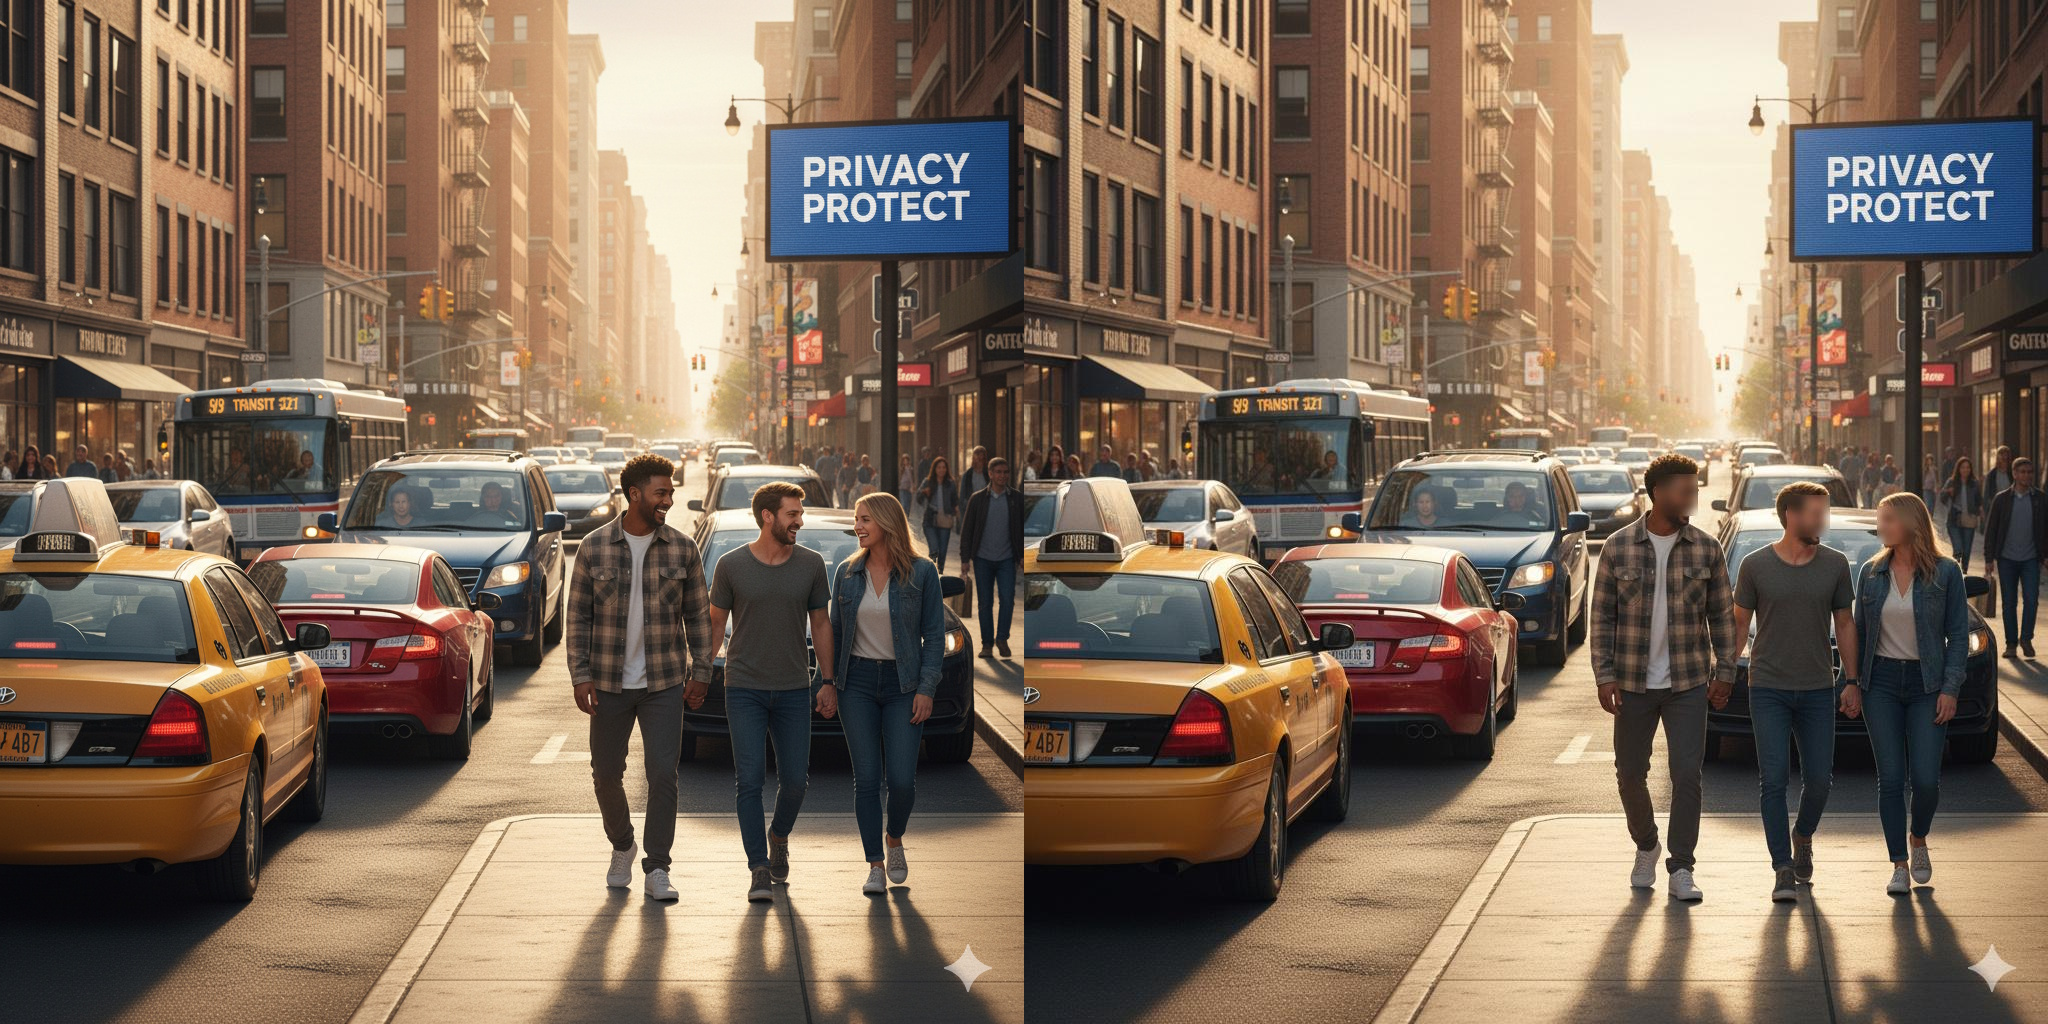

In [ ]:
# --- 4.2 Test Image Endpoint (Synchronous) ---

import requests
import json
from PIL import Image
import io
from IPython.display import display

# --- !!! EDIT THIS FILENAME !!! ---
TEST_IMAGE_PATH = "test_image.jpg" # Change this to your uploaded image file
# ---

# SERVICE_URL is a global var set by the output of cell 3.6
IMAGE_API_URL = f"{SERVICE_URL}/v1/anonymize-image"

# Define our options, per SRS 5.2
options_payload = {
    "targets": {
        "faces": True,
        "plates": True,
        "text": False,
        "logos": False
    },
    "mode": "blur",
    "confidence_threshold": 0.4
}

# --- CORRECTED PAYLOAD ---
# 'data' argument for 'requests' should be a simple dict for form fields
data_payload = {
    "options": json.dumps(options_payload)
}
# ---

print(f"Testing IMAGE endpoint at: {IMAGE_API_URL}")
print(f"Uploading file: {TEST_IMAGE_PATH}")

try:
    with open(TEST_IMAGE_PATH, 'rb') as f:
        # 'files' argument is for the file upload
        files_payload = {'file': (TEST_IMAGE_PATH, f, 'image/jpeg')}

        # Make the POST request
        response = requests.post(IMAGE_API_URL, data=data_payload, files=files_payload)

    # Check for success (SRS 5.3.1)
    if response.status_code == 200:
        print("\n--- SUCCESS (Status 200) ---")
        print("Received anonymized image back.")

        # Display the "before" and "after" images
        print("Displaying 'BEFORE' (left) and 'AFTER' (right):")
        img_before = Image.open(TEST_IMAGE_PATH)
        img_after = Image.open(io.BytesIO(response.content))

        # Create a combined image for side-by-side comparison
        combined_img = Image.new('RGB', (img_before.width + img_after.width, img_before.height))
        combined_img.paste(img_before, (0, 0))
        combined_img.paste(img_after, (img_before.width, 0))
        display(combined_img)

    else:
        print(f"\n--- ERROR (Status {response.status_code}) ---")
        print(f"Response Body: {response.text}")

except FileNotFoundError:
    print(f"ERROR: Test file not found at '{TEST_IMAGE_PATH}'")
    print("Please upload the file and update the TEST_IMAGE_PATH variable.")
except Exception as e:
    print(f"\n--- REQUEST FAILED ---")
    print(f"An error occurred: {e}")

## 4.3 Test 'Coordinates Only' Mode

In [ ]:
# --- 4.3 Test 'Coordinates Only' Mode ---

print(f"Testing 'coordinates_only' mode...")

# Define options for coordinates_only
options_payload_coords = {
    "targets": {
        "faces": True,
        "plates": True,
        "text": True,
        "logos": True
    },
    "coordinates_only": True
}

# 'data' argument for 'requests' should be a simple dict for form fields
data_payload_coords = {
    "options": json.dumps(options_payload_coords)
}

try:
    with open(TEST_IMAGE_PATH, 'rb') as f:
        files_payload_coords = {'file': (TEST_IMAGE_PATH, f, 'image/jpeg')}
        # IMAGE_API_URL is a global var set in 4.2
        response = requests.post(IMAGE_API_URL, data=data_payload_coords, files=files_payload_coords)

    if response.status_code == 200:
        print("\n--- SUCCESS (Status 200) ---")
        print("Received JSON response:")
        print(json.dumps(response.json(), indent=2))
    else:
        print(f"\n--- ERROR (Status {response.status_code}) ---")
        print(f"Response Body: {response.text}")

except FileNotFoundError:
    print(f"ERROR: Test file not found at '{TEST_IMAGE_PATH}'")
except Exception as e:
    print(f"\n--- REQUEST FAILED ---")
    print(f"An error occurred: {e}")

Testing 'coordinates_only' mode...

--- SUCCESS (Status 200) ---
Received JSON response:
{
  "detected_objects": [
    {
      "type": "face",
      "confidence": 0.92578125,
      "bbox": [
        763,
        495,
        806,
        537
      ]
    },
    {
      "type": "face",
      "confidence": 0.9453125,
      "bbox": [
        632,
        474,
        674,
        516
      ]
    },
    {
      "type": "face",
      "confidence": 0.91015625,
      "bbox": [
        853,
        506,
        891,
        544
      ]
    }
  ]
}


## 4.4 Test Video Endpoint (Asynchronous)

In [ ]:
# --- 4.4 Test Video Endpoint (Asynchronous) ---

import time
from datetime import datetime, timezone
import requests
import json

# --- !!! EDIT THIS FILENAME !!! ---
TEST_VIDEO_PATH = "test_video.mp4" # Change this to your uploaded video file
# ---

VIDEO_API_URL = f"{SERVICE_URL}/v1/anonymize-video"
JOB_API_URL_BASE = f"{SERVICE_URL}/v1/jobs"

# Define our options
options_payload_video = {
    "targets": {
        "faces": True,
        "plates": True
    },
    "mode": "pixelate",
    "compliance_profile": "hipaa_like"
}

data_payload_video = {
    "options": json.dumps(options_payload_video)
}

print(f"Testing VIDEO endpoint at: {VIDEO_API_URL}")
print(f"Uploading file: {TEST_VIDEO_PATH}")

job_id = None
OUTPUT_FILENAME = "anonymized_video.mp4"

try:
    # --- PART 1: SUBMIT THE VIDEO (SRS 5.3.2) ---
    with open(TEST_VIDEO_PATH, 'rb') as f:
        files_payload_video = {'file': (TEST_VIDEO_PATH, f, 'video/mp4')}
        response = requests.post(VIDEO_API_URL, data=data_payload_video, files=files_payload_video)

    if response.status_code == 202:
        print("\n--- SUCCESS (Status 202) ---")
        job_data = response.json()
        job_id = job_data.get("job_id")
        print(f"Video accepted. Job ID: {job_id}")

    else:
        print(f"\n--- ERROR (Status {response.status_code}) ---")
        print(f"Response Body: {response.text}")
        raise Exception("Failed to submit video.")

    # --- PART 2: POLL THE JOB STATUS (SRS 5.3.3) ---
    if job_id:
        JOB_STATUS_URL = f"{JOB_API_URL_BASE}/{job_id}"
        print(f"\nPolling job status at: {JOB_STATUS_URL}")

        status = ""
        timeout_seconds = 300 # 5 minute timeout
        start_time = time.time()

        while True:
            if time.time() - start_time > timeout_seconds:
                raise Exception("Job polling timed out.")

            job_response = requests.get(JOB_STATUS_URL)

            # Check for video response (200 OK)
            if job_response.status_code == 200 and job_response.headers.get('content-type') == 'video/mp4':
                print(f"  {time.strftime('%H:%M:%S')}: Job status: COMPLETED")
                print("\n--- JOB COMPLETED ---")

                # Save the video bytes to a file
                with open(OUTPUT_FILENAME, "wb") as f:
                    f.write(job_response.content)
                print(f"Success! Anonymized video saved to: {OUTPUT_FILENAME}")
                break

            # Check for JSON status responses (RUNNING, FAILED, etc.)
            try:
                job_data = job_response.json()
                status = job_data.get("status")
                print(f"  {time.strftime('%H:%M:%S')}: Job status: {status}")

                if status == "FAILED":
                    print("\n--- JOB FAILED ---")
                    print(f"Error: {job_data.get('error')}")
                    break

            except requests.exceptions.JSONDecodeError:
                # This is expected for 404s while the job is spinning up
                print(f"  {time.strftime('%H:%M:%S')}: Job not found yet (404) or non-JSON response. Waiting...")

            time.sleep(10) # Wait 10 seconds before polling again

except FileNotFoundError:
    print(f"ERROR: Test file not found at '{TEST_VIDEO_PATH}'")
    print("Please upload the file and update the TEST_VIDEO_PATH variable.")
except Exception as e:
    print(f"\n--- REQUEST FAILED ---")
    print(f"An error occurred: {e}")

Testing VIDEO endpoint at: https://privacyscrub-api-whbrskh54q-uc.a.run.app/v1/anonymize-video
Uploading file: test_video.mp4

--- SUCCESS (Status 202) ---
Video accepted. Job ID: job_03160c20-aaad-4e30-acae-33988c36e3ec

Polling job status at: https://privacyscrub-api-whbrskh54q-uc.a.run.app/v1/jobs/job_03160c20-aaad-4e30-acae-33988c36e3ec
  17:57:59: Job status: COMPLETED

--- JOB COMPLETED ---
Success! Anonymized video saved to: anonymized_video.mp4
